In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
# import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *
from proc_revisions.ss_sj_utils import *

In [2]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [3]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
cerb_gtf = od+expand(config['lr']['cerberus']['gtf'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]
pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='human')[0]
gtf = od+expand(config['lr']['cerberus']['gtf'], species='human')[0]
alu = od+config['ref']['repeats']['alu_bed']
phastcons = od+config['ref']['phastcons100']['txt']


ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]


ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'protein_coding'
obs_col = 'sample'
go_gene_subset = 'protein_coding'

m_ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='mouse')[0]
m_filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='mouse')[0]
m_read_annot = od+expand(config['lr']['talon']['full_annot'], species='mouse')[0]
m_t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='mouse')[0]
m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]
m_swan_file = od+expand(config['lr']['swan']['sg'], species='mouse')[0]
m_cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='mouse', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='mouse')[0]
m_major_isos = od+expand(config['lr']['analysis']['major_isos'], species='mouse', obs_col='sample')[0]
m_pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='mouse', obs_col='sample')[0]
m_pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='mouse')[0]
m_cerb_gtf = od+expand(config['lr']['cerberus']['gtf'], species='mouse')[0]
human_mouse_sect_cons = '../fig5/human_mouse_sect_cons.tsv'


m_ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='mouse')[0]
m_ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='mouse')[0]


orth_table = od+config['ref']['orth_genes']

mouse_ver = 'vM25_cerberus'

In [7]:
def test_print_stat(df, test_col, test='mannwhitneyu'):
    # means of each dist and mann whitney u for each pair
    for s in df.sector_human.unique().tolist():
        print()
        for c in df.sector_conserved.unique().tolist():
            temp = df.loc[(df.sector_human==s)&\
                          (df.sector_conserved==c)].copy(deep=True)
            print(f"Mean of human {s} {c} sector conserved genes: {temp[test_col].mean()}")


    for s in df.sector_human.unique().tolist():
        print()
        for c in df.sector_conserved.unique().tolist():
            temp = df.loc[(df.sector_human==s)&\
                          (df.sector_conserved==c)].copy(deep=True)
            print(f"Median of human {s} {c} sector conserved genes: {temp[test_col].median()}")

    print()
    for s in df.sector_human.unique().tolist():  
        temp = df.loc[df.sector_human==s].copy(deep=True)
        a = temp.loc[temp.sector_conserved==True][test_col].tolist()
        b = temp.loc[temp.sector_conserved==False][test_col].tolist()
        if test=='mannwhitneyu':
            stat, pval = st.mannwhitneyu(a,b,alternative='two-sided')   
            print(f'Mann whitney u human {s} cons vs not cons: {stat}, p={pval}')
        elif test=='ttest_ind':
            stat, pval = st.ttest_ind(a,b,alternative='two-sided')
            print(f'Ttest ind human {s} cons vs not cons: {stat}, p={pval}')
            
def read_cons_table():
    df = pd.read_csv(human_mouse_sect_cons, sep='\t')
    print(len(df.index))
    df['sector_conserved'] = df.sector_human == df.sector_mouse
    df['splicing_conserved']  = (df.sector_human=='splicing')&(df.sector_mouse=='splicing')
    gids = df.loc[(df.sector_human=='splicing')&(df.sector_mouse!='splicing')]['Gene stable ID'].tolist()
    return df

## Intron size : gene body length ratio difference between human and mouse

In [31]:
g_df = pd.read_csv('../../proc_revisions/data/human/lr/cerberus/cerberus_g_info.tsv', sep='\t')
g_df['gid_stable'] = cerberus.get_stable_gid(g_df, 'gid')
g_df = g_df[['gid_stable', 'length']].rename({'length': 'g_len', 
                                       'gid_stable': 'gid_human'}, axis=1)

In [35]:
m_g_df = pd.read_csv('../../proc_revisions/data/mouse/lr/cerberus/cerberus_g_info.tsv', sep='\t')
m_g_df['gid_stable'] = cerberus.get_stable_gid(m_g_df, 'gid')
m_g_df = m_g_df[['gid_stable', 'length']].rename({'length': 'g_len_mouse', 
                                       'gid_stable': 'gid_mouse'}, axis=1)
m_g_df.head()

,gid_mouse,g_len_mouse
0,ENSMUSG00000000544,36373
1,ENSMUSG00000001138,16471
2,ENSMUSG00000003135,11998
3,ENSMUSG00000003464,9839
4,ENSMUSG00000004552,37300


13494


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)



Mean of human tes False sector conserved genes: -4.016317818860418
Mean of human tes True sector conserved genes: -1.6042607905626436

Mean of human splicing False sector conserved genes: 3.2420108402712753
Mean of human splicing True sector conserved genes: -1.023613894435984

Mean of human mixed False sector conserved genes: -3.7704774571968827
Mean of human mixed True sector conserved genes: -2.671732659287135

Mean of human simple False sector conserved genes: 1.5880549274034546
Mean of human simple True sector conserved genes: -3.6483284078529725

Mean of human tss False sector conserved genes: -8.540682358022398
Mean of human tss True sector conserved genes: -3.9240516947350086

Median of human tes False sector conserved genes: -2.7635996654856
Median of human tes True sector conserved genes: -0.2664851792572023

Median of human splicing False sector conserved genes: 3.2925641814386495
Median of human splicing True sector conserved genes: -0.10736925235390515

Median of human mi

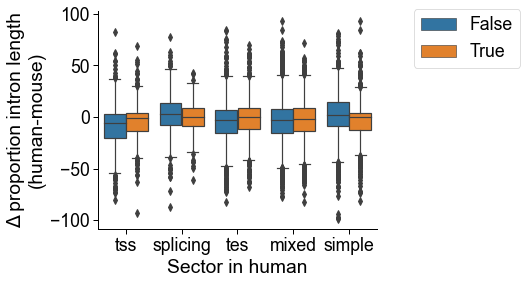

In [39]:
intron_df = pd.read_csv('human_intron_len.tsv', sep='\t')
m_intron_df = pd.read_csv('mouse_intron_len.tsv', sep='\t')

# set nans to 0s (genes w/ no introns)
intron_df.fillna(0, inplace=True)
m_intron_df.fillna(0, inplace=True)

m_intron_df.rename({'mean_intron_len':'m_mean_intron_len',
                    'log_mean_intron_len':'m_log_mean_intron_len',
                    'gid':'Mouse gene stable ID'}, axis=1, inplace=True)
intron_df.rename({'gid':'Gene stable ID'}, axis=1, inplace=True)

df = read_cons_table()
df = df.merge(m_intron_df[['Mouse gene stable ID', 'm_mean_intron_len', 'm_log_mean_intron_len']],
              how='inner',
              on='Mouse gene stable ID')
df = df.merge(intron_df[['Gene stable ID', 'mean_intron_len', 'log_mean_intron_len']],
              how='inner',
              on='Gene stable ID')
df['mean_intron_len_dist'] = df['mean_intron_len']-df['m_mean_intron_len']

# merge in w/ lens of gene bodies
df = df.merge(g_df, how='left', on='gid_human')
assert len(df.loc[df.mean_intron_len > df.g_len].index) == 0
df = df.merge(m_g_df, how='left', on='gid_mouse')
assert len(df.loc[df.m_mean_intron_len > df.g_len_mouse].index) == 0

# get mean prop. of gene body that's introns
df['prop_intron'] = (df.mean_intron_len/df.g_len)*100
df['m_prop_intron'] = (df.m_mean_intron_len/df.g_len_mouse)*100
df['mean_prop_intron_dist'] = df['prop_intron']-df['m_prop_intron']

df['log_mean_prop_intron_dist'] = np.log2(df.mean_prop_intron_dist+0.1)
df.to_csv('mouse_human_prop_intron.tsv', sep='\t')

sns.set_context('paper', font_scale=2)
plt.figure(figsize=(5,4))
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
c_dict, order = get_sector_colors()
ax = sns.boxplot(df, y='mean_prop_intron_dist', x='sector_human',
                 hue='sector_conserved', order=order)
ax.set(xlabel='Sector in human', ylabel=u'Δ proportion intron length\n(human-mouse)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(bbox_to_anchor=(1.1, 1.05))

test_print_stat(df, 'mean_prop_intron_dist', test='ttest_ind')

(-4.98954632195591, 104.78047276107411)

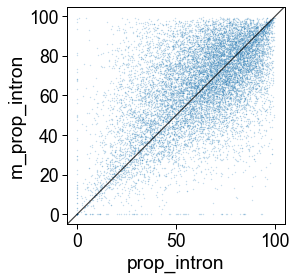

In [48]:
# sns.jointplot(df, x='prop_intron', y='m_prop_intron',
#               joint_kws={'s':2})
ax = sns.scatterplot(df, x='prop_intron', y='m_prop_intron',
                    s=2, alpha=0.25)
lims = [np.min([ax.get_xlim(), ax.get_ylim()]), 
        np.max([ax.get_xlim(), ax.get_ylim()])]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

In [34]:
df.columns

Index(['Gene stable ID', 'Mouse gene stable ID', 'source_human', 'gid_human',
       'n_tss_human', 'n_tes_human', 'n_ic_human', 'n_iso_human',
       'splicing_ratio_human', 'tss_ratio_human', 'tes_ratio_human',
       'spl_ratio_human', 'sector_human', 'gname_human', 'sample_human',
       'gene_tpm_human', 'biotype_category_human', 'source_mouse', 'gid_mouse',
       'n_tss_mouse', 'n_tes_mouse', 'n_ic_mouse', 'n_iso_mouse',
       'splicing_ratio_mouse', 'tss_ratio_mouse', 'tes_ratio_mouse',
       'spl_ratio_mouse', 'sector_mouse', 'gname_mouse', 'sample_mouse',
       'gene_tpm_mouse', 'biotype_category_mouse', 'dist', 'z_score',
       'sector_conserved', 'splicing_conserved', 'm_mean_intron_len',
       'm_log_mean_intron_len', 'mean_intron_len', 'log_mean_intron_len',
       'mean_intron_len_dist', 'g_len'],
      dtype='object')